# Trabajo Práctico Final - Grupo 2
## Matías Bergerman, Pablo González Leiro, Tobias Demeco, Matías Tripoli

Set up (Windows cmd)

1. Crear un entorno virtual (recomendado) e instalar las librerías necesarias:

    `python -m venv venv`

    `.\venv\Scripts\activate`

    `pip install -r ".\TP final - PCB Defect Detection\requirements.txt"`

2. Bajar el token para la API de Kaggle (https://www.kaggle.com/docs/api). Luego bajar la base de datos (1.88GB):

    `cd "TP final - PCB Defect Detection"`

    `kaggle datasets download -d akhatova/pcb-defects`

    `tar -xf pcb-defects.zip`

    `del pcb-defects.zip`

In [137]:
# Import Libraries

import os
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import pandas as pd
import xml.etree.ElementTree as ET 

## Visualización

#### In-line Display

In [138]:
def display_np(x, scale = 1.0, resampling = Image.Resampling.BICUBIC):
    im = Image.fromarray(x.clip(0, 255).astype(np.uint8))
    display(im.resize((np.array(im.size)*scale).astype(int), resampling))
    
def display_np_row(x, scale = 1.0, resampling = Image.Resampling.BICUBIC, spacer_width = 0, spacer_grayscale = 0):
    img = np.array(x, dtype=np.uint8)
    if len(img.shape) <= 3:
        spacer = np.ones((img[0].shape[0], spacer_width), dtype=np.uint8) * spacer_grayscale
    else:
        spacer = np.ones((img[0].shape[0], spacer_width, img[0].shape[2]), dtype=np.uint8) * spacer_grayscale
        
    img_combined = img[0]
    for i in range(1, len(img)):
        img_combined = np.concatenate((img_combined, spacer, img[i]), axis=1)
    display_np(img_combined, scale, resampling)

#### Histogram

In [139]:
def img_histogram(x, ignore_black = False):
    y = np.zeros(256)
    for val in x.flatten().astype(np.uint8):
        y[val] += 1
    if ignore_black:
        result = [0] + y[1:] 
        result /= np.size(x) - y[0]
    else:
        result = y / np.size(x)
    return result

def equalize_histogram(x, ignore_black = False):
    hsum = np.cumsum(img_histogram(x, ignore_black))
    map_level = np.vectorize(lambda p: hsum[p]*255)
    return np.clip(map_level(x), 0, 255).astype(np.uint8)

#### K-Means Clustering

In [140]:
def kmeans_cluster(img, k):
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = img.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)

    # define stopping criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    # number of clusters (K)
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # convert back to 8 bit values
    centers = np.uint8(centers)
    # flatten the labels array
    labels = labels.flatten()
    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(img.shape)

    return segmented_image, labels

def kmeans_disable_clusters(img, labels, k, clusters):
    masked_image = np.copy(img)
    # convert to the shape of a vector of pixel values
    masked_image = masked_image.reshape((-1, 3))
    # color (i.e cluster) to disable
    for cluster in range(k):
        # disable the cluster number (turn the pixel into black)
        if cluster not in clusters:
            masked_image[labels == cluster] = [0, 0, 0]
            
    # convert back to original shape
    masked_image = masked_image.reshape(img.shape)

    return masked_image

#### Constrast

In [141]:
def imadjust(x,a,b,c,d,gamma=1):
    return (((x - a) / (b - a)) ** gamma) * (d - c) + c

def stretch_contrast(x, low_in=0.01, high_in=0.99, low_out=0.0, high_out=1.0):
    # low_in, low_out = r1, s1
    # high_in, high_out = r2, s2
    r1, r2, s1, s2 = 255*low_in, 255*high_in, 255*low_out, 255*high_out

    def T(r):
        if r < r1:
            return imadjust(r, 0, r1, 0, s1)
        elif r < r2:
            return imadjust(r, r1, r2, s1, s2)
        else:
            return imadjust(r, r2, 255, s2, 255)

    vT = np.vectorize(T)
    
    return vT(x).astype(np.uint8)

### Load Test images

In [142]:
# Open Test Image

path_used ="./PCB_DATASET/PCB_USED/"
path_db ="./PCB_DATASET/images/"

img_pcb = cv2.imread(path_db+'Open_circuit/10_open_circuit_03.jpg')
hsv_pcb =  cv2.cvtColor(img_pcb, cv2.COLOR_RGB2HSV)

#### K-means clustering algorithm test

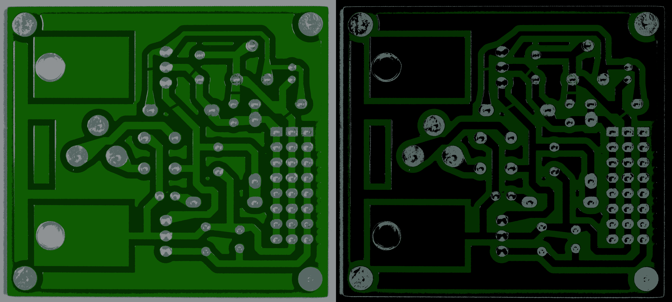

In [143]:
k = 4
pcb_cluster, labels =  kmeans_cluster(img_pcb, k)
pcb_cluster_2 = kmeans_disable_clusters(pcb_cluster, labels, k, [0, 1])

display_np_row([pcb_cluster, pcb_cluster_2], 0.15 )

### Open-circuit detection

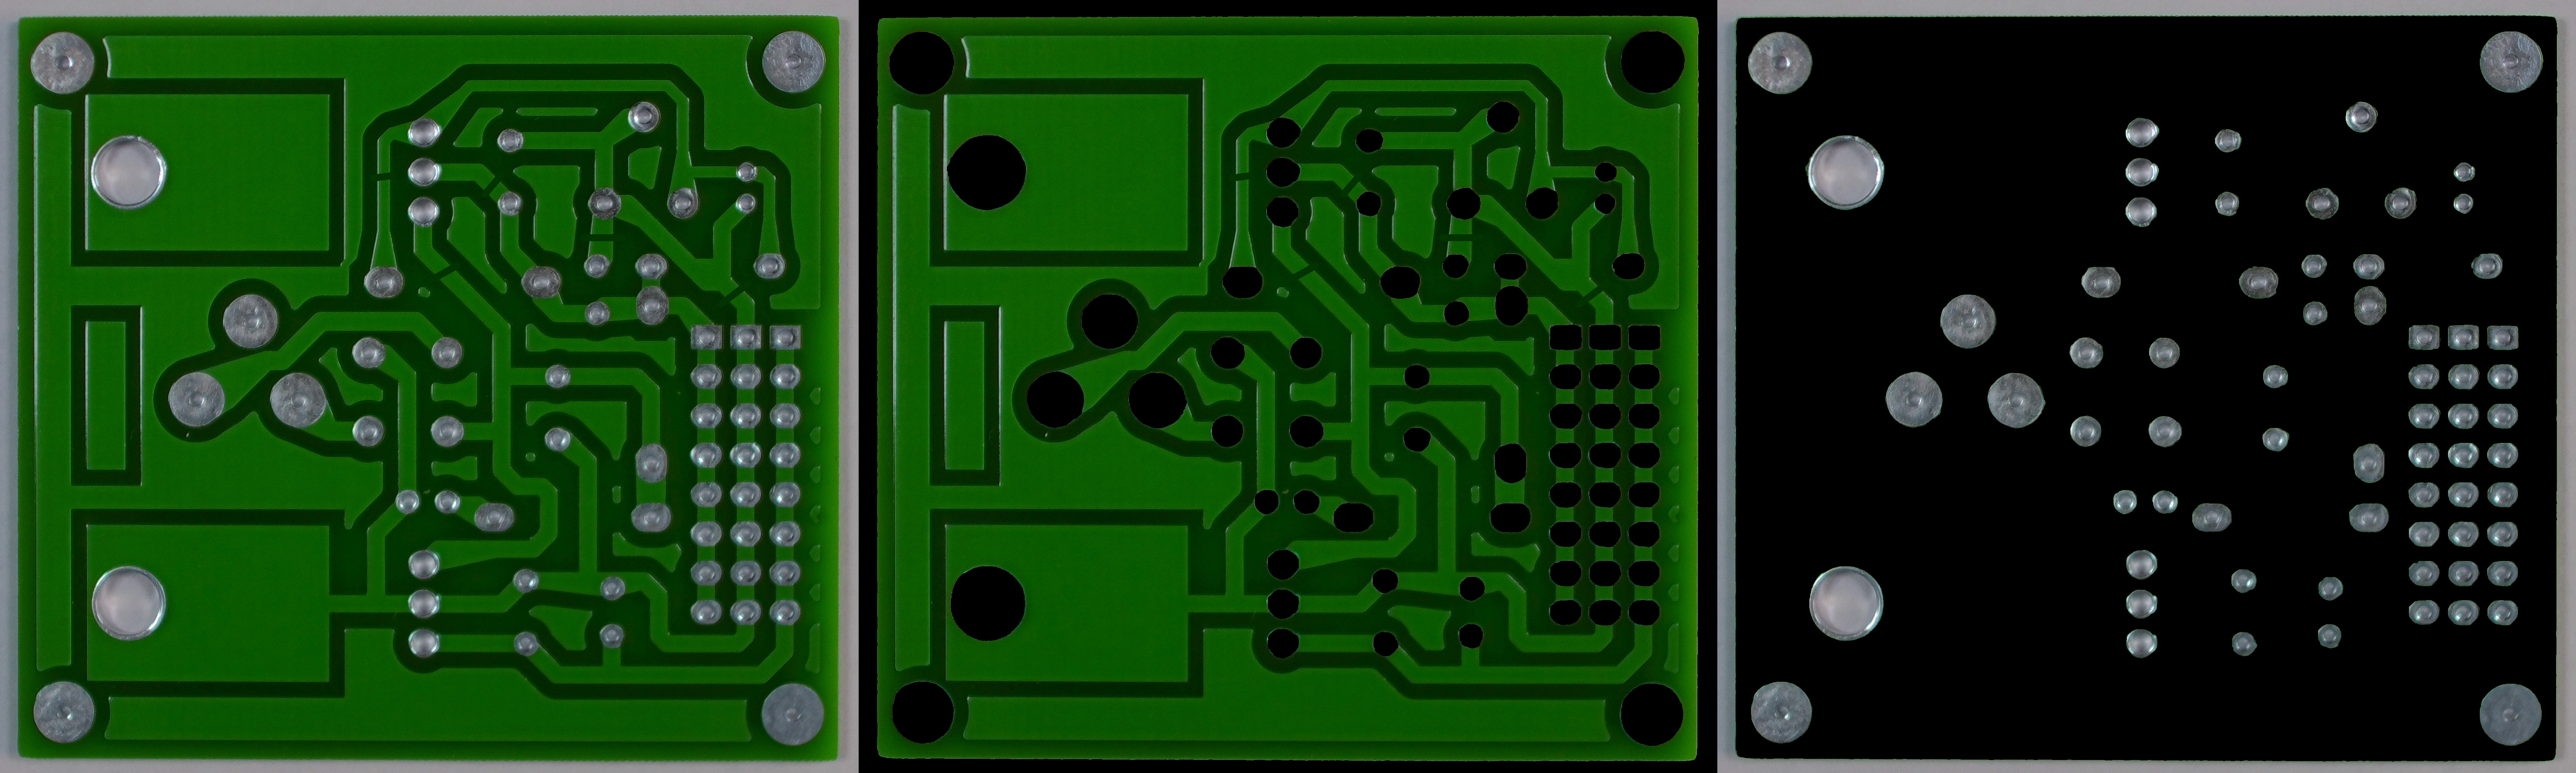

In [144]:
def get_pcb_silk_and_pads(hsv_pcb, light_green = (30, 120, 0), dark_green = (80, 255, 255)):
    mask_pads = cv2.inRange(hsv_pcb, light_green, dark_green)

    # Correct for reflections and small glitches
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))
    mask_pads  = cv2.dilate(mask_pads, kernel)
    mask_pads  = cv2.erode(mask_pads, kernel)

    pcb_silk = cv2.bitwise_and(img_pcb, img_pcb, mask=mask_pads)
    pcb_pads = cv2.bitwise_and(img_pcb, img_pcb, mask=cv2.bitwise_not(mask_pads))

    return pcb_silk, pcb_pads


pcb_silk, pcb_pads = get_pcb_silk_and_pads(hsv_pcb)
display_np_row([img_pcb, pcb_silk, pcb_pads])

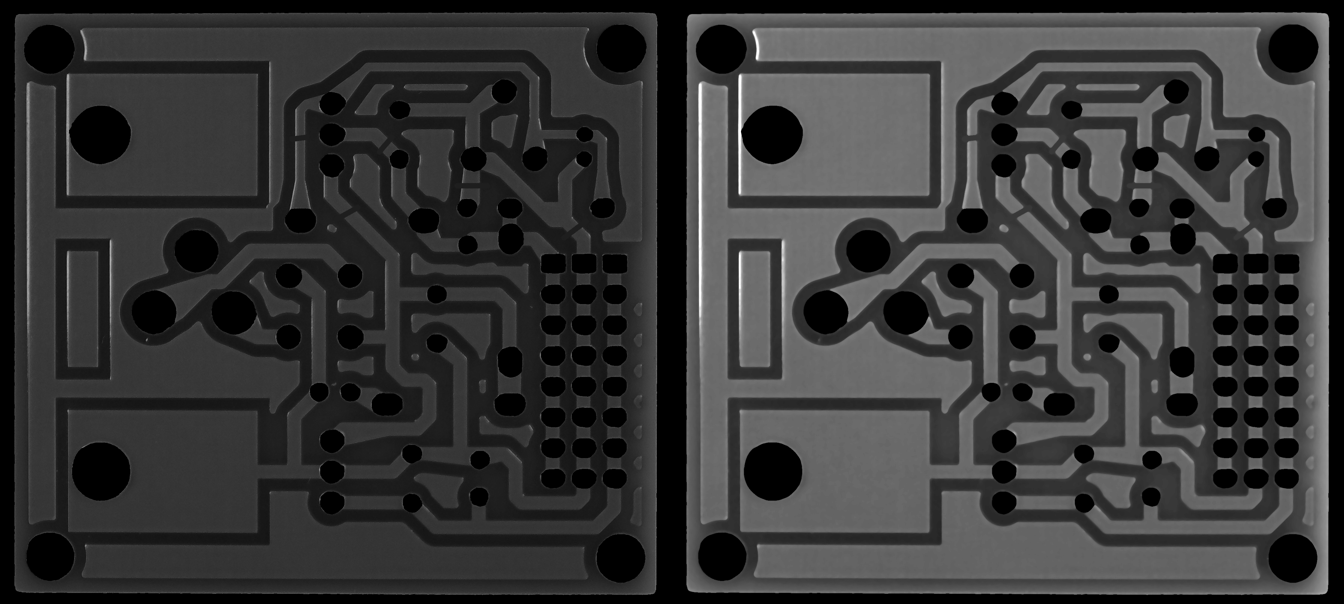

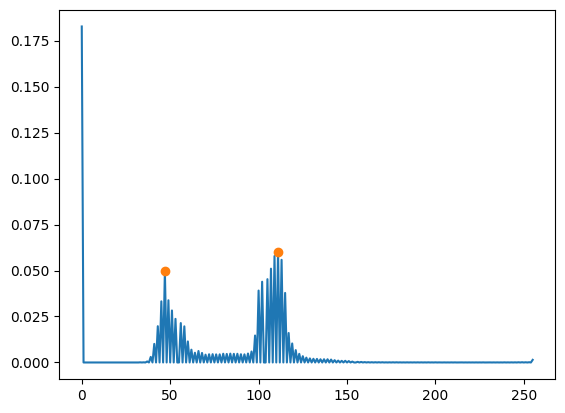

In [145]:
def gray_smooth_pcb(img_pcb):
    pcb_gray = cv2.cvtColor(img_pcb, cv2.COLOR_BGR2GRAY)
    pcb_silk_constrast = stretch_contrast(pcb_gray, low_in=0.01, high_in=0.5, low_out=0.0, high_out=1.0)
    pcb_silk_smooth = cv2.medianBlur(pcb_silk_constrast, 11)

    return pcb_silk_smooth


pcb_silk_smooth = gray_smooth_pcb(pcb_silk) 

display_np_row([cv2.cvtColor(pcb_silk, cv2.COLOR_BGR2GRAY), pcb_silk_smooth], 0.3)

hist = img_histogram(pcb_silk_smooth)

plt.plot(hist)
peaks,_ = find_peaks(hist, distance = 25, prominence = 0.01)
plt.plot(peaks, [hist[i] for i in peaks], 'o')
plt.show()

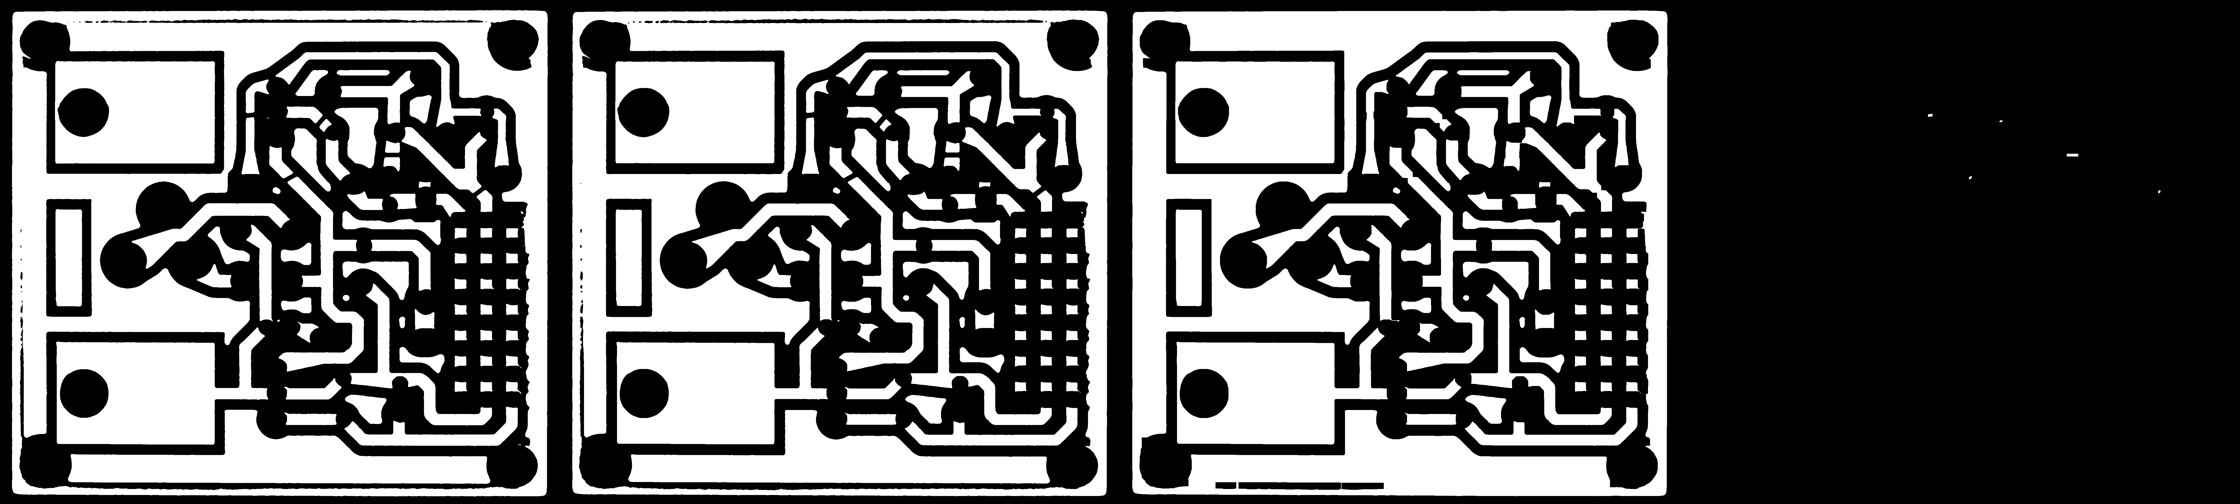

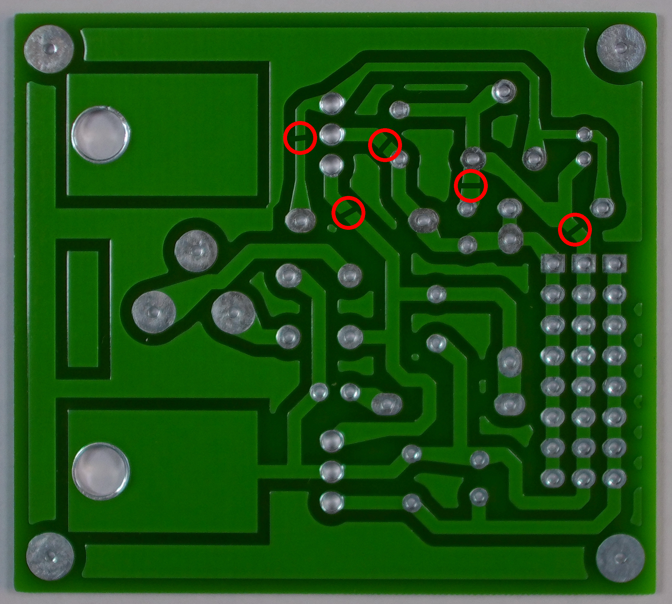

In [146]:
def get_open_circuit_keypoints(img_pcb, ignore_border=120, debug_mode=False):
    peaks,_ = find_peaks(img_histogram(img_pcb), distance = 25, prominence = 0.01)

    pcb_binary = cv2.threshold(img_pcb, (peaks[0]+peaks[1])/2, 255, cv2.THRESH_BINARY)[1]

    kernel = np.ones((3, 3), dtype=np.uint8)
    img_eroded  = cv2.erode(pcb_binary, kernel)

    kernel = np.ones((25, 25), dtype=np.uint8)
    img2  = cv2.dilate(img_eroded, kernel)
    img2  = cv2.erode(img2, kernel)

    kernel = np.ones((10, 10), dtype=np.uint8)
    img3  = cv2.erode(img2-img_eroded, kernel)

    inner_mask = np.zeros_like(img3)
    inner_mask[ignore_border:inner_mask.shape[0]-ignore_border,ignore_border:inner_mask.shape[1]-ignore_border] = True
    img3 = img3 * inner_mask

    if debug_mode:
        display_np_row([pcb_binary, img_eroded, img2, img3], 0.25)


    # Set up the detector with parameters.
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 2
    
    params.filterByCircularity = True
    params.minCircularity = 0.001
    
    params.filterByConvexity = True
    params.minConvexity = 0.01
    
    params.filterByInertia = True
    params.minInertiaRatio = 0.001
    detector = cv2.SimpleBlobDetector_create(params)
    
    # Detect blobs.
    keypoints = detector.detect(cv2.bitwise_not(img3))

    return keypoints


def drawKeyPts(img, keypoints, color, thickness, fixed_size=0):
    for point in keypoints:
        x = int(point.pt[0])
        y = int(point.pt[1])
        size = int(point.size) if fixed_size == 0 else fixed_size
        cv2.circle(img,(x,y),size, color, thickness=thickness, lineType=8, shift=0) 
    return img    


keypoints = get_open_circuit_keypoints(pcb_silk_smooth, debug_mode=True)

im_with_keypoints = drawKeyPts(img_pcb.copy(), keypoints, (255,0,0), 12, fixed_size=50)
display_np(im_with_keypoints, 0.3)

### Mouse-bite detection

#### Hough transform algorithm test

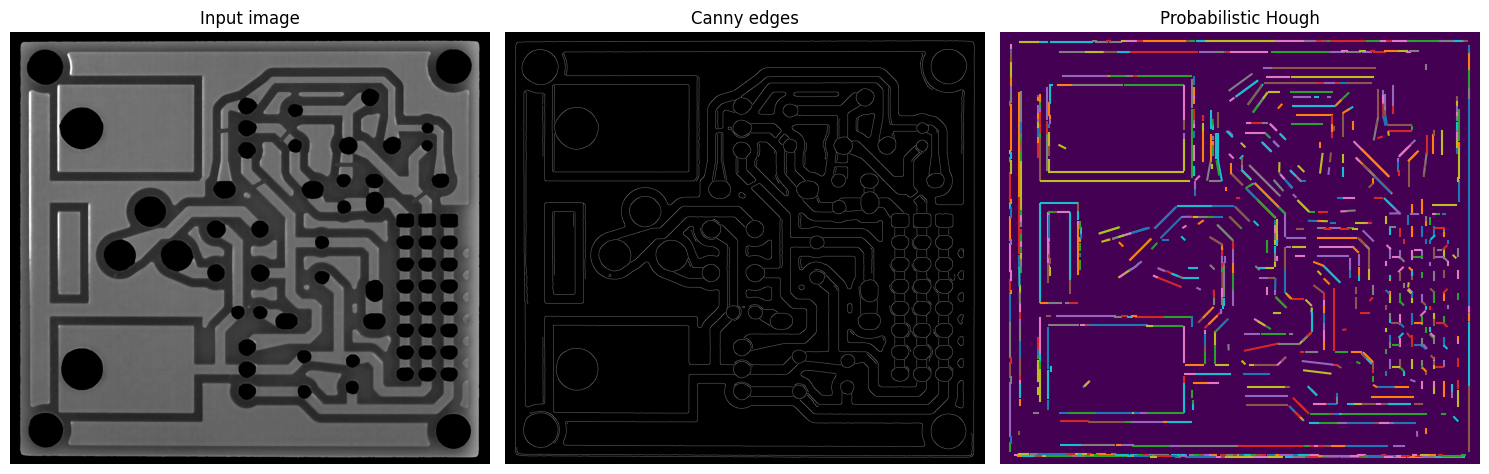

In [147]:
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from matplotlib import cm


# Line finding using the Probabilistic Hough Transform
image = pcb_silk_smooth
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=100, line_length=10,
                                 line_gap=5)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Abrir las anotaciones

In [148]:
path_an = "./PCB_DATASET/Annotations"
print(path_an)

./PCB_DATASET/Annotations


In [149]:
dataset = {
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
            "class":[],    
            "file":[],
            "width":[],
            "height":[],
           }
all_files = []
for path, subdirs, files in os.walk(path_an):
#     print([path, subdirs, files])
    for name in files:
        all_files.append(os.path.join(path, name))

# print(all_files)       
print(type(dataset))
print(dataset)

<class 'dict'>
{'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'file': [], 'width': [], 'height': []}


In [150]:
for annotation in all_files:
    # print(anno)
    tree = ET.parse(annotation)
    
    for elem in tree.iter():
        # print(elem)
        
        if 'size' in elem.tag:
            # print('[size] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            # print('[object] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                
                # print('attr = %s\n' % attr)
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['class']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[annotation.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]         

In [151]:
data=pd.DataFrame(dataset)
data

xmin  ymin  xmax  ymax            class  \
0     2459  1274  2530  1329     missing_hole   
1     1613   334  1679   396     missing_hole   
2     1726   794  1797   854     missing_hole   
3     2584   232  2650   298     missing_hole   
4     2366   803  2406   860     missing_hole   
...    ...   ...   ...   ...              ...   
2948  1777   334  1831   426  spurious_copper   
2949  1395   935  1457   992  spurious_copper   
2950  1837  1441  1871  1530  spurious_copper   
2951  1078  1854  1171  1901  spurious_copper   
2952   311  1632   395  1684  spurious_copper   

                                                   file  width  height  
0           Annotations\Missing_hole\01_missing_hole_01   3034    1586  
1           Annotations\Missing_hole\01_missing_hole_01   3034    1586  
2           Annotations\Missing_hole\01_missing_hole_01   3034    1586  
3           Annotations\Missing_hole\01_missing_hole_02   3034    1586  
4           Annotations\Missing_hole\01_missing_hole_02   3034    1586  
...                                                 ...    ...     ...  
2948  Annotations\Spurious_copper\12_spurious_copper_10   2529    2530  
2949  Annotations\Spurious_copper\12_spurious_copper_10   2529    2530  
2950  Annotations\Spurious_copper\12_spurious_copper_10   2529    2530  
2951  Annotations\Spurious_copper\12_spurious_copper_10   2529    2530  
2952  Annotations\Spurious_copper\12_spurious_copper_10   2529    2530  

[2953 rows x 8 columns]

: 